# Classification of Alzheimer's disease diagnosis

The goal of this lab session is to train a network that will perform a binary classification between the control participants and patients that are affected by Alzheimer's disease. The input of the network is a neuroimaging modality: the T1 weighted MRI. In this project we use the [pytorch library](https://pytorch.org/).


In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy

## Database

In this session we use the images from a public research project: [OASIS-1](https://www.oasis-brains.org/#data).
Two labels exist in this dataset:
- CN (Cognitively Normal) for healthy participants.
- AD (Alzheimer's Disease) for patients affected by Alzheimer's disease.

All the preprocessed images we use were put on github, run the following command to download them.

In [ ]:
! git clone https://github.com/14thibea/OASIS-1_dataset.git

Cloning into 'OASIS-1_dataset'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 675 (delta 21), reused 31 (delta 7), pack-reused 627
Receiving objects: 100% (675/675), 1.31 GiB | 45.55 MiB/s, done.
Resolving deltas: 100% (452/452), done.
Checking out files: 100% (576/576), done.


One crucial step before training a neural network is to check the dataset. Are the classes balanced ? Are there biases in the dataset that may differentiate the labels ?

Here we will focus on the demographics (age, sex and level of education) and two cognitive scores:
- The MMS (Mini Mental State), rated between 0 (no correct answer) to 30 (healthy subject)
- The CDR (Clinical Dementia Rating), that is null if the participant is non-demented and of 0.5, 1, 2 and 3 for very mild, mild, moderate and severe dementia, respectively

In [ ]:
# Load the complete dataset
OASIS_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')

# Study the characteristics of the AD & CN populations (age, sex, MMS, cdr_global)
def characteristics_table(df, merged_df):
    """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""
    diagnoses = np.unique(df.diagnosis.values)
    population_df = pd.DataFrame(index=diagnoses,
                                columns=['N', 'age', '%sexF', 'education',
                                         'MMS', 'CDR=0', 'CDR=0.5', 'CDR=1', 'CDR=2'])
    merged_df = merged_df.set_index(['participant_id', 'session_id'], drop=True)
    df = df.set_index(['participant_id', 'session_id'], drop=True)
    sub_merged_df = merged_df.loc[df.index]

    for diagnosis in population_df.index.values:
        diagnosis_df = sub_merged_df[df.diagnosis == diagnosis]
        population_df.loc[diagnosis, 'N'] = len(diagnosis_df)
        # Age
        mean_age = np.mean(diagnosis_df.age_bl)
        std_age = np.std(diagnosis_df.age_bl)
        population_df.loc[diagnosis, 'age'] = '%.1f ± %.1f' % (mean_age, std_age)
        # Sex
        population_df.loc[diagnosis, '%sexF'] = round((len(diagnosis_df[diagnosis_df.sex == 'F']) / len(diagnosis_df)) * 100, 1)
        # Education level
        mean_education_level = np.nanmean(diagnosis_df.education_level)
        std_education_level = np.nanstd(diagnosis_df.education_level)
        population_df.loc[diagnosis, 'education'] = '%.1f ± %.1f' % (mean_education_level, std_education_level)
        # MMS
        mean_MMS = np.mean(diagnosis_df.MMS)
        std_MMS = np.std(diagnosis_df.MMS)
        population_df.loc[diagnosis, 'MMS'] = '%.1f ± %.1f' % (mean_MMS, std_MMS)
        # CDR
        for value in ['0', '0.5', '1', '2']:
          population_df.loc[diagnosis, 'CDR=%s' % value] = len(diagnosis_df[diagnosis_df.cdr_global == float(value)])

    return population_df

population_df = characteristics_table(OASIS_df, OASIS_df)
print(population_df)

      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   73   77.5 ± 7.4    63  2.7 ± 1.3  22.7 ± 3.6     0      45    26     2
CN  304  44.0 ± 23.3  62.2  3.5 ± 1.2  29.7 ± 0.6   124       0     0     0


## Preprocessing

Theoretically, the main advantage of deep learning methods is to be able to work without extensive data preprocessing. However, as we have only a few images to train the network in this lab session, the preprocessing here is very extensive. More specifically, the images encountered:
1. Non-linear registration
2. Segmentation of grey matter
3. Conversion to tensor format (.pt)

The preprocessed images all have the same size (121x145x121). You will find below a Dataset that allow to browse easily the database.

In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler
from os import path

class MRIDataset(Dataset):
    """This dataset include the preprocessed MRI of a list of subjects"""

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            data_df: (DataFrame) list of subjects / sessions used.
            transform: Optional, transformations applied to the tensor
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD":1, "CN":0}

        self.size = self[0]['image'].shape

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        """
        Args:
            idx: (int) the index of the subject/session whom data is loaded.
        Returns:
            sample: (dict) corresponding data described by the following keys:
                image: (Tensor) MR image
                label: (int) the diagnosis code (0 for CN or 1 for AD)
                participant_id: (str) ID of the participant (format sub-...)
                session_id: (str) ID of the session (format ses-M...)
        """

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        """Put all the transforms of the dataset in training mode"""
        self.transform.train()

    def eval(self):
        """Put all the transforms of the dataset in evaluation mode"""
        self.transform.eval()

To facilitate the training and avoid overfitting due to the limited amount of data, the network won't use the full image but only a part of the image centered on a specific neuroanatomical region: the hippocampus (HC).
This structure is known to be linked to memory, and is atrophied in the majority of cases of Alzheimer's disease patients.

To improve the training and reduce overfitting, a random shift was added to the cropping function. This means that the bounding box around the hippocampus may be shifted by a limited amount of voxels in each of the three directions.

By using a random shift, we generate several patches with one original MRI: this is called **data augmentation**. This can be very useful for training as it artificially increases the amount of data (though theses samples are very correlated of course). However this is not used during evaluation to obtain a deterministic result. This is why these functions have a training and an evaluation mode.

In [ ]:
class CropLeftHC(object):
    """Crops the left hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 25 + x:55 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

class CropRightHC(object):
    """Crops the right hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 65 + x:95 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

## Visualization

Here we visualize the raw, preprocessed and cropped data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


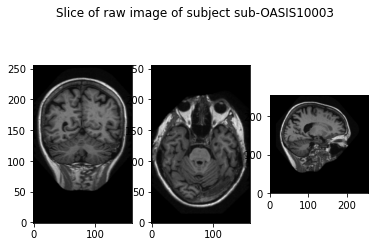

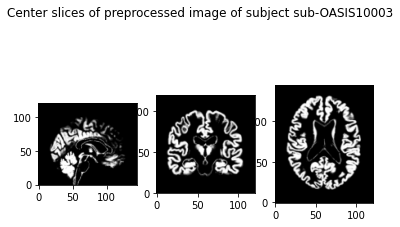

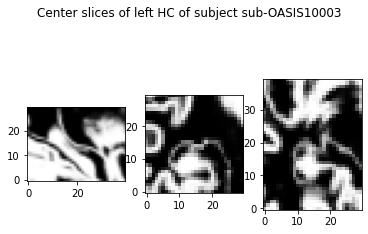

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load('OASIS-1_dataset/preprocessed/%s_ses-M00_' % subject +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
raw_nii = nib.load('OASIS-1_dataset/raw/%s_ses-M00_T1w.nii.gz' % subject) # Nifti1Image (wrapper on a numpy array with metadata)
raw_np = raw_nii.get_data() # Numpy array

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = raw_np[80, :, :]
slice_1 = raw_np[:, 130, :]
slice_2 = raw_np[:, :, 60]
show_slices([rotate(slice_0, 90), rotate(slice_1, 90), slice_2])
plt.suptitle('Slice of raw image of subject %s' % subject)
plt.show()

slice_0 = preprocessed_pt[0, 60, :, :]
slice_1 = preprocessed_pt[0, :, 72, :]
slice_2 = preprocessed_pt[0, :, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle('Center slices of preprocessed image of subject %s' % subject)
plt.show()

leftHC_pt = CropLeftHC()(preprocessed_pt)
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle('Center slices of left HC of subject %s' % subject)
plt.show()

# Validation

In order to choose hyperparameters the set of images is divided into a training set (80%) and a validation set (20%). The data split was performed in order to ensure a similar distribution of diagnosis, age and sex between the subjects of the training set and the subjects of the validation set. Moreover the MMS distribution of each class is preserved.

In [ ]:
train_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_population_df = characteristics_table(train_df, OASIS_df)
valid_population_df = characteristics_table(valid_df, OASIS_df)
print("Train")
print(train_population_df)
print()
print("Validation")
print(valid_population_df)

Train
      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   58   77.4 ± 7.5    69  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  242  43.4 ± 23.5    62  3.6 ± 1.2  29.8 ± 0.5    97       0     0     0

Validation
     N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15   78.2 ± 6.6    40  2.5 ± 1.0  22.9 ± 3.6     0       8     7     0
CN  62  46.3 ± 22.6  62.9  3.4 ± 1.3  29.6 ± 0.7    27       0     0     0


We can observe that our dataset is biased: the AD and CN populations do not have the same age distributions at all! It becomes then very easy to differentiate them as the age regression between 20 and 95 years old is an easier task than AD vs CN classification.

To avoid this bias, the youngest participants of OASIS are removed from the training and validation DataFrames. More precisely, to match the AD population in which the youngest participant is 62, all participants younger than 62 are removed.

In [ ]:
train_df = train_df[['participant_id']].merge(OASIS_df, how='left', on='participant_id', sort=False)
train_df = train_df[train_df.age_bl >= 62]
valid_df = valid_df[['participant_id']].merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_df = valid_df[valid_df.age_bl >= 62]

train_population_df = characteristics_table(train_df, OASIS_df)
valid_population_df = characteristics_table(valid_df, OASIS_df)
print("Train")
print(train_population_df)
print()
print("Validation")
print(valid_population_df)

Train
     N         age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  58  77.4 ± 7.5    69  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  65  76.3 ± 8.6  73.8  3.3 ± 1.2  29.3 ± 0.7    65       0     0     0

Validation
     N         age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15  78.2 ± 6.6    40  2.5 ± 1.0  22.9 ± 3.6     0       8     7     0
CN  17  77.2 ± 6.4  76.5  3.4 ± 1.4  29.2 ± 0.7    17       0     0     0


# Model
We propose here to design a convolutional neural network that takes for input a patch centered on the left hippocampus of size 30x40x30. The architecture of the network was found using a Random Search on architecture + optimization hyperparameters.


## Reminder on CNN layers

In a CNN everything is called a layer though the operations layers perform are very different. You will find below a summary of the different operations that may be performed in a CNN.


### Feature maps

The outputs of the layers in a convolutional network are called feature maps. Their size is written with the format:

> `n_channels @ dim1 x dim2 x dim3`

For a 3D CNN the dimension of the feature maps is actually 5D as the first dimension is the batch size. This dimension is added by the `DataLoader` of pytorch which stacks the 4D tensors computed by a `Dataset`.

In [ ]:
img_dir = path.join('OASIS-1_dataset', 'preprocessed')
batch_size=4

example_dataset = MRIDataset(img_dir, OASIS_df, transform=CropLeftHC())
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)
for data in example_dataloader:
    pass

print("Shape of Dataset output\n", example_dataset[0]['image'].shape)
print()
print("Shape of DataLoader output\n", data['image'].shape)

Shape of Dataset output
 torch.Size([1, 30, 40, 30])

Shape of DataLoader output
 torch.Size([4, 1, 30, 40, 30])



### Convolutions (`nn.Conv3d`)

The main arguments of this layer are the input channels, the output channels (number of filters trained) and the size of the filter (or kernel). If an integer `k` is given the kernel will be a cube of size `k`. It is possible to construct rectangular kernels by entering a tuple (but this is very rare).

You will find below an illustration of how a single filter produces its output feature map by parsing the one feature map. The size of the output feature map produced depends of the convolution parameters and can be computed with the following formula:

> $O_i = \frac{I_i-k+2P}{S} + 1$

*   $O_i$ the size of the output along the ith dimension
*   $I_i$ the size of the input along the ith dimension
*   $k$ the size of the kernel
*   $P$ the padding value
*   $S$ the stride value

In the following example $\frac{5-3+2*0}{1}+1 = 3$

![2D convolutional layer gif](https://drive.google.com/uc?id=166EuqiwIZkKPMOlVzA-v5WemJE2tDCES)

To be able to parse all the feature maps of the input, one filter is actually a 4D tensor of size `(input_channels, k, k, k)`. The ensemble of all the filters included in one convolutional layer is then a 5D tensor stacking all the filters of size `(output_channels, input_channels, k, k, k)`.

Each filter is also associated to one bias value that is a scalar added to all the feature maps it produces. Then the bias is a 1D vector of size `output_channels`.

In [ ]:
from torch import nn

conv_layer = nn.Conv3d(8, 16, 3)
print('Weights shape\n', conv_layer.weight.shape)
print()
print('Bias shape\n', conv_layer.bias.shape)

Weights shape
 torch.Size([16, 8, 3, 3, 3])

Bias shape
 torch.Size([16])


### Batch Normalization (`nn.BatchNorm3d`)

Learns to normalize feature maps according to [(Ioffe & Szegedy, 2015)](https://arxiv.org/abs/1502.03167). The following formula is applied on each feature map  $FM_i$:

> $FM^{normalized}_i = \frac{FM_i - mean(FM_i)}{\sqrt{var(FM_i) + \epsilon}} * \gamma_i + \beta_i$

*   $\epsilon$ is a hyperparameter of the layer (default=1e-05)
*   $\gamma_i$ is the value of the scale for the ith channel (learnable parameter)
*   $\beta_i$ is the value of the shift for the ith channel (learnable parameter)

This layer does not have the same behaviour during training and evaluation, this is why it is needed to put the model in evaluation mode in the test function with the command `.eval()`

In [ ]:
batch_layer = nn.BatchNorm3d(16)
print('Gamma value\n', batch_layer.state_dict()['weight'].shape)
print()
print('Beta value\n', batch_layer.state_dict()['bias'].shape)

Gamma value
 torch.Size([16])

Beta value
 torch.Size([16])


### Activation function (`nn.LeakyReLU`)

In order to introduce non-linearity in the model, an activation function is introduced after the convolutions. It is applied on all intensities independently.

The graph of the Leaky ReLU is displayed below, $\alpha$ being a hyperparameter of the layer (default=0.01):

![Leaky ReLU graph](https://sefiks.com/wp-content/uploads/2018/02/prelu.jpg?w=600)

### Pooling function (`PadMaxPool3d`)

The structure of the pooling layer is very similar to the convolutional layer: a kernel is passing through the input with a defined size and stride. However there is no learnable parameters in this layer, the kernel outputing the maximum value of the part of the feature map it covers.

Here is an example in 2D of the standard layer of pytorch `nn.MaxPool2d`:

![nn.MaxPool2d behaviour](https://drive.google.com/uc?id=1qh9M9r9mfpZeSD1VjOGQAl8zWqBLmcKz)

We can observe that the last column may not be used depending on the size of the kernel/input and stride value.

This is why the custom module `PadMaxPool` was defined to pad the input in order to exploit information from the whole feature map.


In [ ]:
class PadMaxPool3d(nn.Module):
    """A MaxPooling module which deals with odd sizes with padding"""
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride - f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output

Here is an illustration of `PadMaxPool` behaviour, a column is added to avoid losing data:

![PadMaxPool behaviour](https://drive.google.com/uc?id=14R_LCTiV0N6ZXm-3wQCj_Gtc1LsXdQq_)

Similarly, the formula to find the size of the output feature map is:

> $O_i = ceil(\frac{I_i-k+2P}{S}) + 1$

### Flatten (`nn.Flatten`)

This layer flattens the array to a 1D array. This operation is necessary between the 3D convolutions and the fully-connected layers.

You also can perform the flatten operation in the `forward` method of the network with `view()`.

In [ ]:
flatten = nn.Flatten()
input_tensor = torch.rand(8, 16, 4, 5, 4)
output_tensor = flatten(input_tensor)

print("Shape of the output tensor", output_tensor.shape)

Shape of the output tensor torch.Size([8, 1280])


### Dropout (`nn.Dropout`)

The aim of a dropout layer is to replace a fixed proportion of the input values by 0 during training only.

This layer does not have the same behaviour during training and evaluation, this is why it is needed to put the model in evaluation mode in the test function with the command `.eval()`

In [ ]:
dropout = nn.Dropout(0.5)
input_tensor = torch.rand(10)
output_tensor = dropout(input_tensor)
print("Input \n", input_tensor)
print()
print("Output \n", output_tensor)

Input 
 tensor([0.0385, 0.1832, 0.3846, 0.6744, 0.7320, 0.4741, 0.7226, 0.2521, 0.9493,
        0.1822])

Output 
 tensor([0.0000, 0.3664, 0.0000, 0.0000, 0.0000, 0.0000, 1.4451, 0.5042, 1.8987,
        0.3644])


### Fully-Connected Layers (`nn.Linear`)

The fully connected layers take as input 2D vectors of size `(batch_size, N)`. They have two mandatory arguments, the number of values per batch of the input and the number of values per batch of the output.

Each output neuron in a FC layer is a linear combination of the inputs + a bias.

In [ ]:
fc = nn.Linear(16, 2)
print("Weights shape \n", fc.weight.shape)
print()
print("Bias shape \n", fc.bias.shape)

Weights shape 
 torch.Size([2, 16])

Bias shape 
 torch.Size([2])


## TODO Network design
Construct here the network corresponding to the scheme and the following description:

![Scheme of the network](https://drive.google.com/uc?id=1Qi-ictqudBX4ToBXzqT5w57RHrkn3MPR)

The network includes 3 convolutional blocks composed by a convolutional layer (kernel size = 3, padding = 1, stride = 1), a batch normalization, a LeakyReLU activation and a MaxPooling layer. The 3 successive layers include respectively 8, 16 and 32 filters.

Then, the feature maps array is flattened in a 1D array to enter a fully-connected layer. Between the convolutional and the fully-connected layers, a dropout layer with a dropout rate of 0.5 is inserted.  

In [ ]:
class CustomNetwork(nn.Module):

    def __init__(self):
        super(CustomNetwork, self).__init__()
        # Create the layers composing the network
        pass

    def forward(self, x):
        # Compose the forward operation using the layers defined in __init__
        pass

# Train & Test

Complete here the `train` method in order to iteratively update the weights of the network.

Here the model leading to the lowest loss on the training set is returned, however we could choose instead the model leading to the highest balanced accuracy, or the one obtained on the last iteration.

In some frameworks a validation set is also used to know when the training should be stopped (early stopping) and / or to identify and keep the best model.

In [ ]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train a CNN

    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Complete the train iteration

        resu,train_metrics = test(model, train_loader, criterion)

        print('Epoch %i: loss = %f, balanced accuracy = %f'
              % (epoch, train_metrics['mean_loss'],
                 train_metrics['balanced_accuracy']))

        if train_metrics['mean_loss'] < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = train_metrics['mean_loss']

    return best_model

def test(model, data_loader, criterion):
    """
    Method used to test a CNN

    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images

    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = nn.Softmax(dim=1)(outputs)
            _, predicted = torch.max(outputs.data, 1)

            for idx, sub in enumerate(data['participant_id']):
                row = [sub,
                       probs[idx, 0].item(), probs[idx, 1].item(),
                       labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)

    return results_df, results_metrics


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2

    return metrics_dict

## Train Classification with Left HC
Here we will train a first network that will learn the binary classification AD vs CN on a cropped image around the hippocampus.

All hyperparameters may have an influence, but one of the most influent is the learning rate that can lead to a poor convergence if it is too high or low. Try different learning rate between $10 ^{-5}$ and $10 ^{-3}$ and observe the differences of loss variations during training.

To increase the training speed you can also increase the batch size. But be careful, if the batch size becomes a non-negligible amount of the training set it may have a negative impact on loss convergence [(Keskar et al, 2016)](https://arxiv.org/abs/1609.04836).

In [ ]:
# Construction of dataset objects
img_dir = path.join('OASIS-1_dataset', 'preprocessed')
transform = CropLeftHC(2)

train_datasetLeftHC = MRIDataset(img_dir, train_df, transform=transform)
valid_datasetLeftHC = MRIDataset(img_dir, valid_df, transform=transform)

In [ ]:
learning_rate = 10**-4
n_epochs = 30
batch_size = 4

# Put the network on GPU
modelLeftHC = CustomNetwork().cuda()
train_loaderLeftHC = DataLoader(train_datasetLeftHC, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# A high batch size improves test speed
valid_loaderLeftHC = DataLoader(valid_datasetLeftHC, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelLeftHC.parameters(), learning_rate)

best_modelLeftHC = train(modelLeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

Epoch 0: loss = 0.684390, balanced accuracy = 0.500000
Epoch 1: loss = 0.664185, balanced accuracy = 0.552653
Epoch 2: loss = 0.633559, balanced accuracy = 0.571751
Epoch 3: loss = 0.585162, balanced accuracy = 0.727321
Epoch 4: loss = 0.573957, balanced accuracy = 0.678912
Epoch 5: loss = 0.560717, balanced accuracy = 0.666313
Epoch 6: loss = 0.649393, balanced accuracy = 0.563130
Epoch 7: loss = 0.546446, balanced accuracy = 0.628780
Epoch 8: loss = 0.576904, balanced accuracy = 0.683820
Epoch 9: loss = 0.539222, balanced accuracy = 0.704775
Epoch 10: loss = 0.520428, balanced accuracy = 0.715252
Epoch 11: loss = 0.510019, balanced accuracy = 0.700796
Epoch 12: loss = 0.657454, balanced accuracy = 0.597613
Epoch 13: loss = 0.501414, balanced accuracy = 0.699602
Epoch 14: loss = 0.520017, balanced accuracy = 0.711538
Epoch 15: loss = 0.492250, balanced accuracy = 0.716844
Epoch 16: loss = 0.550059, balanced accuracy = 0.709682
Epoch 17: loss = 0.485572, balanced accuracy = 0.726658
Ep

In [ ]:
valid_resultsLeftHC_df, valid_metricsLeftHC = test(best_modelLeftHC, valid_loaderLeftHC, criterion)
train_resultsLeftHC_df, train_metricsLeftHC = test(best_modelLeftHC, train_loaderLeftHC, criterion)
print(valid_metricsLeftHC)
print(train_metricsLeftHC)

{'accuracy': 0.71875, 'sensitivity': 0.5333333333333333, 'specificity': 0.8823529411764706, 'balanced_accuracy': 0.7078431372549019, 'mean_loss': 0.5967844724655151}
{'accuracy': 0.7642276422764228, 'sensitivity': 0.6724137931034483, 'specificity': 0.8461538461538461, 'balanced_accuracy': 0.7592838196286472, 'mean_loss': 0.4454940106810593}


If you obtained about 0.85 or more of balanced accuracy, there may be something wrong... Are you absolutely sure that your dataset is unbiased?

If you didn't remove the youngest subjects of OASIS, your dataset is biased as the AD and CN participants do not have the same age distribution.
In practice people who come to the hospital for a diagnosis of Alzheimer's disease all have about the same age (50 - 90). No one has Alzheimer's disease at 20 ! Then you should check that the performance of the network is still good for the old population only.

## Train Classification with Right HC

Another network can be trained on a cropped image around the right HC network. The same hyperparameters as before may be reused.

In [ ]:
# Construction of dataset objects

transform = CropRightHC(2)

train_datasetRightHC = MRIDataset(img_dir, train_df, transform=transform)
valid_datasetRightHC = MRIDataset(img_dir, valid_df, transform=transform)

In [ ]:
learning_rate = 10**-4
n_epochs = 30
batch_size = 4

modelRightHC = CustomNetwork().cuda()
train_loaderRightHC = DataLoader(train_datasetRightHC, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loaderRightHC = DataLoader(valid_datasetRightHC, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelRightHC.parameters(), learning_rate)

best_modelRightHC = train(modelRightHC, train_loaderRightHC, criterion, optimizer, n_epochs)

Epoch 0: loss = 0.775522, balanced accuracy = 0.500000
Epoch 1: loss = 0.723567, balanced accuracy = 0.500000
Epoch 2: loss = 0.667488, balanced accuracy = 0.598408
Epoch 3: loss = 0.787021, balanced accuracy = 0.500000
Epoch 4: loss = 0.766748, balanced accuracy = 0.508621
Epoch 5: loss = 0.634925, balanced accuracy = 0.591777
Epoch 6: loss = 0.626212, balanced accuracy = 0.616711
Epoch 7: loss = 0.598323, balanced accuracy = 0.672149
Epoch 8: loss = 0.756005, balanced accuracy = 0.517241
Epoch 9: loss = 0.660284, balanced accuracy = 0.545889
Epoch 10: loss = 0.568620, balanced accuracy = 0.697745
Epoch 11: loss = 0.563342, balanced accuracy = 0.723607
Epoch 12: loss = 0.567244, balanced accuracy = 0.681698
Epoch 13: loss = 0.592586, balanced accuracy = 0.733820
Epoch 14: loss = 0.532425, balanced accuracy = 0.705438
Epoch 15: loss = 0.575414, balanced accuracy = 0.660743
Epoch 16: loss = 0.533718, balanced accuracy = 0.707560
Epoch 17: loss = 0.519606, balanced accuracy = 0.701724
Ep

In [ ]:
valid_resultsRightHC_df, valid_metricsRightHC = test(best_modelRightHC, valid_loaderRightHC, criterion)
train_resultsRightHC_df, train_metricsRightHC = test(best_modelRightHC, train_loaderRightHC, criterion)
print(valid_metricsRightHC)
print(train_metricsRightHC)

{'accuracy': 0.75, 'sensitivity': 0.6666666666666666, 'specificity': 0.8235294117647058, 'balanced_accuracy': 0.7450980392156863, 'mean_loss': 0.5673070549964905}
{'accuracy': 0.7560975609756098, 'sensitivity': 0.6896551724137931, 'specificity': 0.8153846153846154, 'balanced_accuracy': 0.7525198938992043, 'mean_loss': 0.47350269507586473}


## Soft voting
To increase the accuracy of our system the results of the two networks can be combined. Here we can give both hippocampi the same weight.

In [ ]:
def softvoting(df1, df2):
    # TODO implement soft voting

In [ ]:
valid_results = softvoting(valid_resultsLeftHC_df, valid_resultsRightHC_df)
valid_metrics = compute_metrics(valid_results.true_label, valid_results.predicted_label)
print(valid_metrics)

{'accuracy': 0.71875, 'sensitivity': 0.6, 'specificity': 0.8235294117647058, 'balanced_accuracy': 0.7117647058823529}


Keep in mind that as you used the validation set was used to set the hyperparameters, the validation metrics are biased. To have unbiased results the entire framework should be evaluated when all the hyperparameters are set on an independent set (test set).

# ViT Transformer

Vision Transformer (ViT) is a pure transformer directly applied to the sequences of image patches for an image classification task. The figure below shows the framework of ViT.

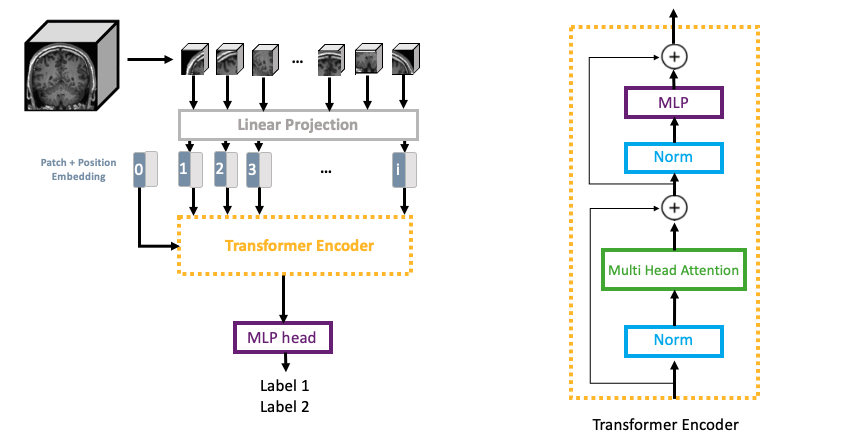

Each 3D MRI is split into a sequence of 3D patches, which are linearly embedded. Position embeddings are added, and sent to a Transformer encoder. A classification token is also added to obtain a global representation of the input image. Finally, a linear classification head is added to perform image classification.



### Useful tools



To implement the ViT Architecture, we will need some new functions that are described in the following cells

**Rearrange**

[einops.rearrange](https://einops.rocks/api/rearrange/) is a reader-friendly smart element reordering for multidimensional tensors. We will use it to divide our 3D input images into 3D patches

In [ ]:
!pip install einops
from einops import rearrange
# Suppose we have an image  in "h w d" format (height-width-depth)
images = np.random.randn(30, 40, 30)
print(images.shape)
# And we want to split this 3D image into smaller patches of size pxpxp
p=10
print(rearrange(images, '(x p1) (y p2) (z p3) -> (x y z) p1 p2 p3', p1=p, p2=p, p3=p).shape) #36 = 3*4*3 = number of patches

# We can also flatten each patch newly created
print(rearrange(images, '(x p1) (y p2) (z p3) -> (x y z) (p1 p2 p3)', p1=p, p2=p, p3=p).shape)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
(30, 40, 30)
(36, 10, 10, 10)
(36, 1000)


**Repeat**



`einops.repeat` allows you to reorder elements and repeating them in arbitrary combinations.

In [ ]:
from einops import repeat

#Let's consider a cls token
cls_token = torch.randn(1, 1, 128)

# We can replicate the cls token along the batch dimension.
b=2
repeat(cls_token, '() n d -> b n d', b=b).shape

torch.Size([2, 1, 128])

**Transformer Encoder** (`nn.TransformerEncoder` and `TransformerEncoderLayer`)

A transformer encoder model as well as transformer encoder layer are already implemented in PyTorch and are based on the paper “Attention Is All You Need” (Ashish Vaswani et al.).




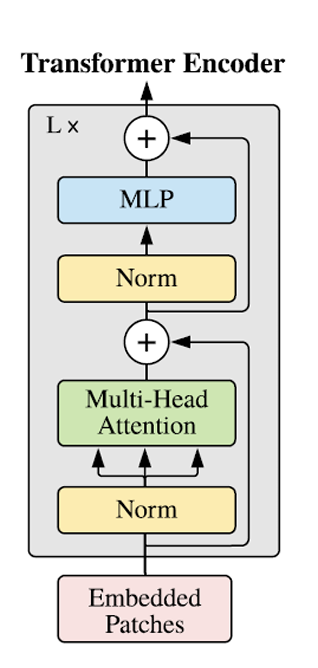

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4, dim_feedforward=256, dropout=0.1, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=12)

src = torch.rand(10, 32, 512)
out = transformer_encoder(src)
print(out.shape)

torch.Size([10, 32, 512])


## TO DO ViT Network Design

Now that we have explored the essential functions required to build a Vision Transformer, it's time for you to implement it.

Follow these key steps:

1. **Patching**: Rearrange your 3D input image into a sequence of 3D patches with dimensions 10x10x10. Utilize the rearrange function to achieve this patching.


2. **Patch Embeddings**: Apply a linear projection layer that maps the flattened input patches to a feature vector of size 128.

3. **Learnable Classification Token**: Define a learnable classification token using a randomly initialized parameter. Concatenate this classification token with the embedded patches. This token will represent the entire sequence during classification.

4. **Learnable Positional Encodings**: Define the learnable positional encodings to the tokenized input before it is processed by the Transformer. This will enable the model to understand the spatial relationships between different patches in the input sequence.

5. **Transformer Encoder**: Implement a Transformer Encoder using the folowing parameters :4 attention heads, a dimension of the feedforward network of 256 and an embedding dimension of 128. You can utilize the nn.TransformerEncoder class with appropriate parameters, such as the dimension of the embedding, number of attention heads, and feedforward dimension.

6. **MLP Head**: Create an MLP head that takes the output feature vector of the CLS token and maps it to a classification prediction. This can be implemented using a small feed-forward network.

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, emb_dim):
        super(ViT, self).__init__()

        # TO DO


    def forward(self, x):

        # Patching : Rearrange input into patches

        # Patch embeddings


        # Classification Token : Replicate the cls token along the batch dimension and concatenate it with embedded patches

        # Add positional embeddings

        # Transformer Encoder

        # MLP Head for final predictions

        return x


## Train Classification with Left HC
Train a ViT that will learn the binary classification AD vs CN on a cropped image around the left hippocampus.




In [ ]:

model = # TO DO



In [ ]:


learning_rate = 10**-4
n_epochs = 150
batch_size = 4

# Put the network on GPU
train_loaderLeftHC = DataLoader(train_datasetLeftHC, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loaderLeftHC = DataLoader(valid_datasetLeftHC, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

best_modelLeftHC = train(model, train_loaderLeftHC, criterion, optimizer, n_epochs)

In [ ]:
valid_resultsRightHC_df, valid_metricsRightHC = test(best_modelLeftHC, valid_loaderLeftHC, criterion)
print(valid_metricsRightHC)

# Bonus : Clustering on AD & CN populations

The classification results above were obtained in a supervised way: neurologists examine the participants of OASIS and gave a diagnosis depending on their clinical symptoms.

However, this label is often inaccurate (Beach et al, 2012).
Then an unsupervised framework can be interesting to check what can be found in data without being biased by a noisy label.

## Model

A convenient architecture to extract features from an image with deep learning is the autoencoder (AE). This architecture is made of two parts:
- the **encoder** which learns to compress the image in a smaller vector, the **code**. *It is composed of the same kind of operations than the convolutional part of the CNN seen before.*
- the **decoder** which learns to reconstruct the original image from the code learnt by the encoder. *It is composed of the transposed version of the operations used in the encoder.*

You will find below `CropMaxUnpool3d` the transposed version of `PadMaxPool3d`.

In [ ]:
class CropMaxUnpool3d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool3d, self).__init__()
        self.unpool = nn.MaxUnpool3d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[4]
            y1 = padding[2]
            z1 = padding[0]
            output = output[:, :, x1::, y1::, z1::]

        return output

To facilitate the reconstruction process, the pooling layers in the encoder return the position of the values that were the maximum. Hence the unpooling layer can replace the maximum values at the right place in the 2x2x2 sub-cube of the feature map. They also indicate if some zero padding was applied to the feature map so that the unpooling layer can correctly crop their output feature map.  

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (15, 20, 15)

            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (8, 10, 8)

            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (4, 5, 4)

            nn.Conv3d(32, 1, 1),
            # Size (4, 5, 4)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(1, 32, 1),

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(32, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(16, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(8, 1, 3, padding=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        indices_list = []
        pad_list = []
        for layer in self.encoder:
            if isinstance(layer, PadMaxPool3d):
                x, indices, pad = layer(x)
                indices_list.append(indices)
                pad_list.append(pad)
            elif isinstance(layer, nn.MaxPool3d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)

        code = x.view(x.size(0), -1)
        for layer in self.decoder:
            if isinstance(layer, CropMaxUnpool3d):
                x = layer(x, indices_list.pop(), pad_list.pop())
            elif isinstance(layer, nn.MaxUnpool3d):
                x = layer(x, indices_list.pop())
            else:
                x = layer(x)

        return code, x

## Train Autoencoder

The training function of the autoencoder is very similar to the training function of the CNN. The main difference is that the loss is not computed by comparing the output with the diagnosis values using the cross-entropy loss, but with the original image using for example the Mean Squared Error (MSE) loss.

In [ ]:
def trainAE(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train an AutoEncoder

    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            @TODO
            # Complete the training function in a similar way
            # than for the CNN classification training.

        mean_loss = testAE(model, train_loader, criterion)

        print('Epoch %i: loss = %f' % (epoch, mean_loss))

        if mean_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss

    return best_model


def testAE(model, data_loader, criterion):
    """
    Method used to test an AutoEncoder

    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images

    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            _, outputs = model((images))
            loss = criterion(outputs, images)
            total_loss += loss.item()

    return total_loss / len(data_loader.dataset) / np.product(data_loader.dataset.size)

In [ ]:
learning_rate = 10**-2
n_epochs = 30
batch_size = 4

AELeftHC = AutoEncoder().cuda()
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(AELeftHC.parameters(), learning_rate)

best_AELeftHC = trainAE(AELeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

Epoch 0: loss = 0.058143
Epoch 1: loss = 0.031748
Epoch 2: loss = 0.026381
Epoch 3: loss = 0.022619
Epoch 4: loss = 0.018505
Epoch 5: loss = 0.017163
Epoch 6: loss = 0.016044
Epoch 7: loss = 0.014597
Epoch 8: loss = 0.014278
Epoch 9: loss = 0.013595
Epoch 10: loss = 0.013623
Epoch 11: loss = 0.013577
Epoch 12: loss = 0.012757
Epoch 13: loss = 0.012305
Epoch 14: loss = 0.012682
Epoch 15: loss = 0.012023
Epoch 16: loss = 0.011879
Epoch 17: loss = 0.011674
Epoch 18: loss = 0.011706
Epoch 19: loss = 0.011385
Epoch 20: loss = 0.011627
Epoch 21: loss = 0.011734
Epoch 22: loss = 0.011257
Epoch 23: loss = 0.011383
Epoch 24: loss = 0.011808
Epoch 25: loss = 0.011791
Epoch 26: loss = 0.011116
Epoch 27: loss = 0.011214
Epoch 28: loss = 0.011183
Epoch 29: loss = 0.011121


## Visualization

The simplest way to check if the AE training went well is to visualize the output and compare it to the original image seen by the autoencoder.

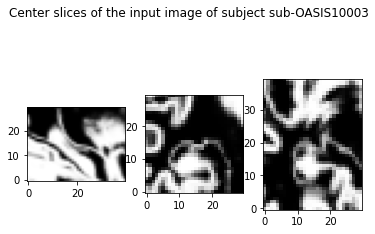

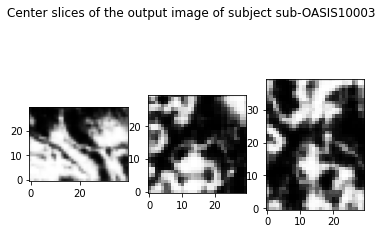

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load('OASIS-1_dataset/preprocessed/%s_ses-M00_' % subject +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
input_pt = CropLeftHC()(preprocessed_pt).unsqueeze(0).cuda()
_, output_pt = best_AELeftHC(input_pt)


slice_0 = input_pt[0, 0, 15, :, :].cpu()
slice_1 = input_pt[0, 0, :, 20, :].cpu()
slice_2 = input_pt[0, 0, :, :, 15].cpu()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle('Center slices of the input image of subject %s' % subject)
plt.show()

slice_0 = output_pt[0, 0, 15, :, :].cpu().detach()
slice_1 = output_pt[0, 0, :, 20, :].cpu().detach()
slice_2 = output_pt[0, 0, :, :, 15].cpu().detach()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle('Center slices of the output image of subject %s' % subject)
plt.show()

## Clustering

Now that the AE extracted the most salient parts of the image in a smaller vector, the features obtained can be used for clustering.

Here we give an example with the Gaussian Mixture Model (GMM) of scikit-learn. To use it we first need to concat the features and the labels of all the subjects in two matrices *X* and *Y*. This is what is done in `compute_dataset_features` method.

In [ ]:
def compute_dataset_features(data_loader, model):

    concat_codes = torch.Tensor().cuda()
    concat_labels = torch.LongTensor()
    concat_names = []

    for data in data_loader:
      image = data['image'].cuda()
      labels = data['label']
      names = data['participant_id']

      code, _ = model(image)
      concat_codes = torch.cat([concat_codes, code.squeeze(1)], 0)
      concat_labels = torch.cat([concat_labels, labels])
      concat_names = concat_names + names

    concat_codes_np = concat_codes.cpu().detach().numpy()
    concat_labels_np = concat_labels.numpy()
    concat_names = np.array(concat_names)[:, np.newaxis]

    return concat_codes_np, concat_labels_np, concat_names

In [ ]:
train_codes, train_labels, names = compute_dataset_features(train_loaderLeftHC, best_AELeftHC)

Then the model will fit the training codes and build two clusters. The labels found in this unsupervised way can be compared to the true labels.

In [ ]:
from sklearn import mixture


n_components = 2
model = mixture.GaussianMixture(n_components)
model.fit(train_codes)
train_predict = model.predict(train_codes)

metrics = compute_metrics(train_labels, train_predict)
print(metrics)

{'accuracy': 0.6585365853658537, 'sensitivity': 0.5689655172413793, 'specificity': 0.7384615384615385, 'balanced_accuracy': 0.653713527851459}


The accuracy may not be very good, this could mean that the framework classified another characteristic that the one you tried to target. Remember that if your (balanced) accuracy is below 0.5, this is because the clustering algorithm does not know that the first label (0) correponds to CN and the second one (1) to AD. Compute (1 - your value) to obtain the real one.

What is actually expected is that the clustering differenciation is made on the level of atrophy, which is mostly correlated to the age but also to the disease stage (we can model it with the MMS score).

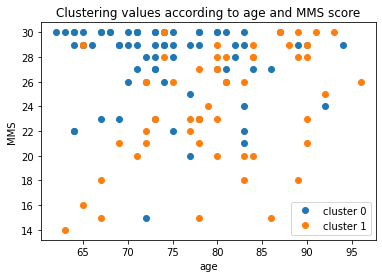

In [ ]:
data_np = np.concatenate([names, train_codes,
                          train_labels[:, np.newaxis],
                          train_predict[:, np.newaxis]], axis=1)
columns = ['feature %i' % i for i in range(train_codes.shape[1])]
columns = ['participant_id'] + columns + ['true_label', 'predicted_label']
data_df = pd.DataFrame(data_np, columns=columns).set_index('participant_id')

merged_df = data_df.merge(OASIS_df.set_index('participant_id'), how='inner', on='participant_id')

plt.title('Clustering values according to age and MMS score')
for component in range(n_components):
    predict_df = merged_df[merged_df.predicted_label == str(component)]
    plt.plot(predict_df['age_bl'], predict_df['MMS'], 'o', label="cluster %i" % component)
plt.legend()
plt.xlabel('age')
plt.ylabel('MMS')
plt.show()

You can try to improve this clustering by adding the codes obtained on the right hippocampus, perform further dimension reduction or remove age effect like in [(Moradi et al, 2015)](https://www.researchgate.net/publication/266374876_Machine_learning_framework_for_early_MRI-based_Alzheimer%27s_conversion_prediction_in_MCI_subjects)...